#### 1. Importing the required libraries

In [ ]:
import os
import re
import unicodedata
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Input
from tensorflow.keras.layers import Embedding, LSTM, Dense, TimeDistributed, Layer
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau

#### 2. Global parameters

In [ ]:
# Data related
root_location   = '/content/drive/MyDrive/NLP_Project/'
input_data_name = 'news_summary.csv'
extra_data_name = 'news_summary_more.csv' 

# Parameters related to data preparation
START_TOKEN = '<start> '
END_TOKEN = ' <end>'
EMBEDDING_DIM = 100

In [ ]:
input_df = pd.read_csv(root_location + input_data_name, encoding='latin-1', usecols=['headlines', 'text'])
extra_df = pd.read_csv(root_location + extra_data_name)

augmented_input_df = pd.concat([input_df, extra_df])

#### 3. Dataset summary

In [ ]:
pd.read_csv(root_location + input_data_name, encoding='latin-1').shape

(4514, 6)

In [ ]:
augmented_input_df.shape

(102915, 2)

In [ ]:

augmented_input_df.shape

(102915, 2)

#### 4. Sample data

In [ ]:
import textwrap
for i in range(5):
  print("TEXT: ", '\n'.join(textwrap.wrap(augmented_input_df.loc[i, 'text'].values[0], width=150, replace_whitespace=False)))
  print("SUMMARY: ", augmented_input_df.loc[i, 'headlines'].values[0])
  print()

TEXT:  The Administration of Union Territory Daman and Diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on
the occasion of Rakshabandhan on August 7. The administration was forced to withdraw the decision within 24 hours of issuing the circular after it
received flak from employees and was slammed on social media.
SUMMARY:  Daman & Diu revokes mandatory Rakshabandhan in offices order

TEXT:  Malaika Arora slammed an Instagram user who trolled her for "divorcing a rich man" and "having fun with the alimony". "Her life now is all about
wearing short clothes, going to gym or salon, enjoying vacation[s]," the user commented. Malaika responded, "You certainly got to get your damn facts
right before spewing sh*t on me...when you know nothing about me."
SUMMARY:  Malaika slams user who trolled her for 'divorcing rich man' 

TEXT:  The Indira Gandhi Institute of Medical Sciences (IGIMS) in Patna on Thursday made corrections in its Marital Decla

#### 5. Data pre-processing

In [ ]:
def preprocess(df, columns):
  for f in columns:
    text_set = []
    for _, row in df.iterrows():
      text = ''.join(
          c for c in unicodedata.normalize('NFD', row[f]) if unicodedata.category(c) != 'Mn'
      )
      text = text.lower()

      patterns_to_replace_1 = ["(\\t)", "(\\r)", "(\\n)", "(__+)", "(--+)", "(~~+)", "(\+\++)", "(\.\.+)", r"[<>()|&©ø\[\]\'\",;?~*!]", 
                                "(mailto:)", r"(\\x9\d)", "(\.\s+)", "(\-\s+)","(\:\s+)", "(\s+.\s+)"]

      for pattern in patterns_to_replace_1:
        text = re.sub(pattern, ' ', text)
                              
      try:
          url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', text)
          repl_url = url.group(3)
          text = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, text)
      except:
          pass #there might be emails with no url in them

      patterns_to_replace_2 = ["(\s+)", "(\s+.\s+)"]

      for pattern in patterns_to_replace_2:
        text = re.sub(pattern, ' ', text)
      text_set.append(text)

    df[f] = text_set
  return df

In [ ]:
augmented_input_df = (augmented_input_df.pipe(preprocess, columns = ['headlines', 'text']))

In [ ]:
import textwrap
for i in range(5):
  print("TEXT: ", '\n'.join(textwrap.wrap(augmented_input_df.loc[i, 'text'].values[0], width=150, replace_whitespace=False)))
  print("SUMMARY: ", augmented_input_df.loc[i, 'headlines'].values[0])
  print()

TEXT:  the administration of union territory daman and diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on
the occasion of rakshabandhan on august the administration was forced to withdraw the decision within 24 hours of issuing the circular after it
received flak from employees and was slammed on social media.
SUMMARY:  daman diu revokes mandatory rakshabandhan in offices order

TEXT:  malaika arora slammed an instagram user who trolled her for divorcing rich man and having fun with the alimony her life now is all about wearing short
clothes going to gym or salon enjoying vacation the user commented malaika responded you certainly got to get your damn facts right before spewing sh
on me when you know nothing about me
SUMMARY:  malaika slams user who trolled her for divorcing rich man 

TEXT:  the indira gandhi institute of medical sciences igims in patna on thursday made corrections in its marital declaration form by changing virgin op

#### 6. Exploratory data analysis

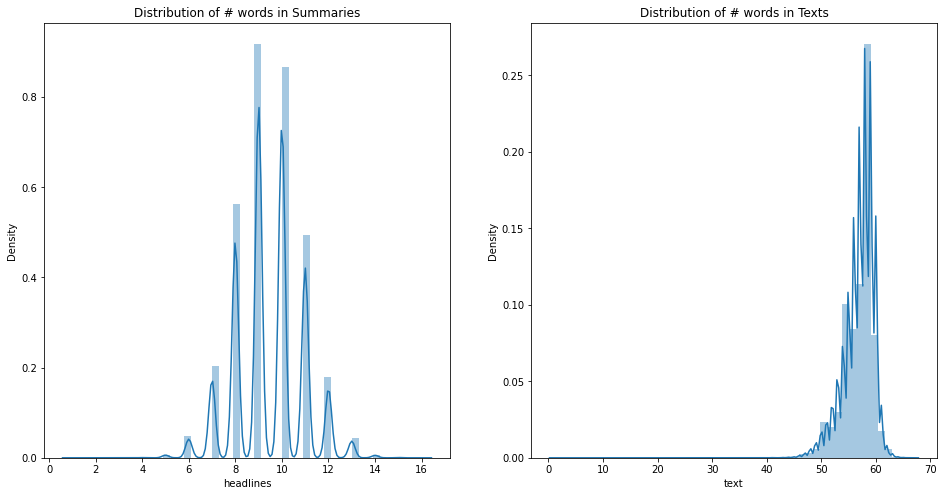

In [ ]:
length_of_headlines = augmented_input_df['headlines'].str.split().apply(len)
length_of_texts     = augmented_input_df['text'].str.split().apply(len)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
sns.distplot(length_of_headlines)
plt.title('Distribution of # words in Summaries')

plt.subplot(1, 2, 2)
sns.distplot(length_of_texts)
plt.title('Distribution of # words in Texts')

plt.show()

In [ ]:
# Checking mean lengths
print(f'Mean headline length: {round(length_of_headlines.mean(),2)}')
print(f'Mean text length: {round(length_of_texts.mean(),2)}')

Mean headline length: 9.44
Mean text length: 56.92


In [ ]:
# Check how much % of headlines have 0-15 words
print(f"Headlines having length in range [0, 15]: {round(len(length_of_headlines[length_of_headlines <= 15])/len(length_of_headlines),4)*100}")

# Check how much % of text have 0-6 words
print(f"Text having length in range [0, 62]: {round(len(length_of_texts[length_of_texts <= 62])/len(length_of_texts),4)*100}")

Headlines having length in range [0, 15]: 100.0
Text having length in range [0, 62]: 99.75


In [ ]:
MAX_TEXT_SEQ_LEN = 62
MAX_HEADLINE_SEQ_LEN = 15

In [ ]:
augmented_input_df['summaries_input'] = START_TOKEN + augmented_input_df['headlines']
augmented_input_df['summaries_output'] = augmented_input_df['headlines'] + END_TOKEN

In [ ]:
X_train, X_test = train_test_split(augmented_input_df, test_size=0.1)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

print(X_train.shape)
print(X_test.shape)

(92623, 4)
(10292, 4)


In [ ]:
X_train.head(2)

,headlines,text,summaries_input,summaries_output
0,vatican diplomat admits to possessing child po...,a catholic priest who worked as diplomat at th...,<start> vatican diplomat admits to possessing ...,vatican diplomat admits to possessing child po...
1,north korea icbm test brings us closer to war us,north korea intercontinental ballistic missile...,<start> north korea icbm test brings us closer...,north korea icbm test brings us closer to war ...


In [ ]:
X_train['summaries_input'][0], X_train['summaries_output'][0] 

('<start> vatican diplomat admits to possessing child pornography',
 'vatican diplomat admits to possessing child pornography <end>')

#### 7. Data preparation for training & testing 

In [ ]:
def prepare_train_data(X, tokenizers = None):
    """Tokenize and pad the given text."""
    
    if tokenizers is None:
      tokenizers = {}

      text_tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
      text_tokenizer.fit_on_texts(X['text'])
      tokenizers['text'] = text_tokenizer

      X['summaries_input'][0] = X['summaries_input'][0] + END_TOKEN
      summmary_tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
      summmary_tokenizer.fit_on_texts(X['summaries_input'])
      tokenizers['summary'] = summmary_tokenizer

    else:
      text_tokenizer     = tokenizers['text']
      summmary_tokenizer = tokenizers['summary']
    
    # Pad sequences
    text_input = pad_sequences(text_tokenizer.texts_to_sequences(X['text']), maxlen=MAX_TEXT_SEQ_LEN, padding='post', truncating='post')

    summary_input  = pad_sequences(summmary_tokenizer.texts_to_sequences(X['summaries_input']), maxlen=MAX_HEADLINE_SEQ_LEN, padding='post', truncating='post')
    summary_output = pad_sequences(summmary_tokenizer.texts_to_sequences(X['summaries_output']), maxlen=MAX_HEADLINE_SEQ_LEN, padding='post', truncating='post')

    return text_input, summary_input, summary_output, tokenizers

In [ ]:
text_train_input, summary_train_input, summary_train_output, tokenizers = prepare_train_data(X_train)
text_test_input, summary_test_input, summary_test_output, _ = prepare_train_data(X_train, tokenizers)

In [ ]:
text_vocab_size    = len(tokenizers['text'].word_index) + 1
summary_vocab_size = len(tokenizers['summary'].word_index) + 1

print(f'Text vocab size: {text_vocab_size}')
print(f'Headline vocab size: {summary_vocab_size}')

Text vocab size: 79899
Headline vocab size: 34657


#### 8. Glove embeddings for text & summary tokens

In [ ]:
%%time
embeddings_index = dict()
f = open('/content/drive/MyDrive/NLP/Assignment_2/Q1/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1: ], dtype='float32')
    embeddings_index[word] = coefs
f.close()

summary_embedding_matrix = np.zeros((summary_vocab_size, EMBEDDING_DIM))
for word, token in tokenizers['summary'].word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        summary_embedding_matrix[token] = embedding_vector

text_embedding_matrix = np.zeros((text_vocab_size, EMBEDDING_DIM))
for word, token in tokenizers['text'].word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        text_embedding_matrix[token] = embedding_vector

CPU times: user 9.85 s, sys: 619 ms, total: 10.5 s
Wall time: 10.3 s


In [ ]:
print(f'Shape of headline embedding matrix: {summary_embedding_matrix.shape}')
print(f'Shape of text embedding matrix: {text_embedding_matrix.shape}')

Shape of headline embedding matrix: (34657, 100)
Shape of text embedding matrix: (79899, 100)


#### 9. Model definition & training

In [ ]:
class Encoder(Layer):
    def __init__(self, name):
        super().__init__(name=name)
        
        self.embedding = Embedding(input_dim=text_vocab_size, output_dim=EMBEDDING_DIM, 
                                   weights=[text_embedding_matrix], input_length=MAX_TEXT_SEQ_LEN, 
                                   trainable=True, name='encoder_embedding')
        self.lstm = LSTM(units=128, return_sequences=True, return_state=True, name='encoder_lstm')

    def call(self, x):
        x = self.embedding(x)
        self.lstm_output, self.lstm_hidden, self.lstm_cell = self.lstm(x)
        return self.lstm_output, self.lstm_hidden, self.lstm_cell
    
    def get_states(self):
        return self.lstm_hidden, self.lstm_cell

class Decoder(Layer):
    def __init__(self, name):
        super().__init__(name=name)
        
        self.embedding = Embedding(input_dim=summary_vocab_size, output_dim=EMBEDDING_DIM, 
                                   trainable=True, weights=[summary_embedding_matrix], 
                                   input_length=None, name='decoder_embedding')
        self.lstm = LSTM(units=128, return_sequences=True, return_state=True, name='decoder_lstm')
    
    
    def call(self, x, lstm_hidden, lstm_cell):
        x = self.embedding(x)
        lstm_output, lstm_hidden, lstm_cell = self.lstm(x, initial_state=[lstm_hidden, lstm_cell])
        return lstm_output, lstm_hidden, lstm_cell

class EncoderDecoderModel(Model):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder(name='encoder')
        self.decoder = Decoder(name='decoder')
        self.decoder_dense = TimeDistributed(Dense(units=summary_vocab_size, activation='softmax'), name='decoder_dense')
    
    
    def call(self, x):
        text, summary = x
        _, hidden_state, cell_state = self.encoder(text)
        out, hidden_state, cell_state = self.decoder(summary, hidden_state, cell_state)
        return self.decoder_dense(out)

In [ ]:
model = EncoderDecoderModel()

In [ ]:
optimizer = Adam(learning_rate=0.002)

model.compile(optimizer = optimizer, loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1
)

# Train the model
history = model.fit(
    [text_train_input, summary_train_input],
    summary_train_output,
    batch_size=512,
    epochs=60,
    validation_data=([text_test_input, summary_test_input],summary_test_output),
    callbacks=[reduce_lr]
)

Epoch 1/60
181/181 [==============================] - 82s 434ms/step - loss: 6.9350 - accuracy: 0.2825 - val_loss: 5.2811 - val_accuracy: 0.3730
Epoch 2/60
181/181 [==============================] - 77s 427ms/step - loss: 5.2002 - accuracy: 0.3762 - val_loss: 4.9133 - val_accuracy: 0.3859
Epoch 3/60
181/181 [==============================] - 77s 427ms/step - loss: 4.8581 - accuracy: 0.3881 - val_loss: 4.6341 - val_accuracy: 0.3981
Epoch 4/60
181/181 [==============================] - 77s 428ms/step - loss: 4.5987 - accuracy: 0.4014 - val_loss: 4.3894 - val_accuracy: 0.4127
Epoch 5/60
181/181 [==============================] - 77s 427ms/step - loss: 4.3523 - accuracy: 0.4147 - val_loss: 4.1494 - val_accuracy: 0.4249
Epoch 6/60
181/181 [==============================] - 77s 428ms/step - loss: 4.1217 - accuracy: 0.4270 - val_loss: 3.9356 - val_accuracy: 0.4377
Epoch 7/60
181/181 [==============================] - 78s 430ms/step - loss: 3.9174 - accuracy: 0.4386 - val_loss: 3.7471 - val_ac

In [ ]:
model1 = model

#### 10. Model Diagnostics

In [ ]:
def plot(history):
    plt.figure(figsize=(12, 6))
    plt.style.use('ggplot')
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(0, len(history.history['loss'])), history.history['loss'], label='train_loss')
    plt.plot(np.arange(0, len(history.history['val_loss'])), history.history['val_loss'], label='validation_loss')

    plt.title('Epochs vs. Loss')
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.style.use('ggplot')
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(0, len(history.history['accuracy'])), history.history['accuracy'], label='train_accuracy')
    plt.plot(np.arange(0, len(history.history['val_accuracy'])), history.history['val_accuracy'], label='validation_accuracy')

    plt.title('Epochs vs. Accuracy')
    plt.xlabel('Epoch #')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

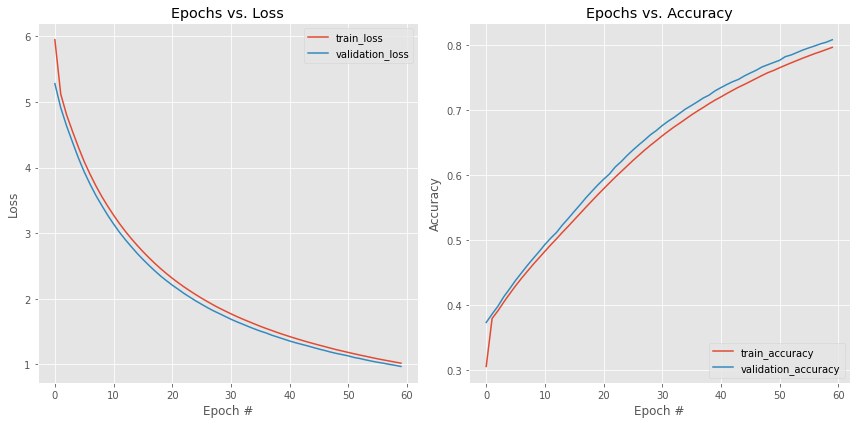

In [ ]:
plot(history)

In [ ]:
# Inspecting model layers
for idx, layer in enumerate(model.layers):
    print(f'{idx} => {layer.name}')

0 => encoder
1 => decoder
2 => decoder_dense


In [ ]:
len(tokenizers['summary'].word_index.items())

34656

In [ ]:
index_to_word_text, index_to_word_headline  = {}, {}

for key, val in tokenizers['text'].word_index.items():
    index_to_word_text[val] = key

for key, val in tokenizers['summary'].word_index.items():
    index_to_word_headline[val] = key
    
index_to_word_text[0] = '<pad>'
index_to_word_headline[0] = '<pad>'

In [ ]:
# Example text to summarize
sample_text = text_test_input[0]
sample_text

array([   49,  5667,  3679,    27,  1069,    19,  5761,    21,     1,
        6347,    41,  2327,     7,   825,     2,     1,  3790,     5,
        3546,     4,   518,  7009,    44,  1637,     3,     1,    98,
       51341, 17669, 30180, 25394,     9,    16,  2431,    34,     1,
        1886,     4,   778,  1645, 14156,    20,    16,  2216,     2,
           1,    41,    13,    33,   333,     3,  1789,    21,   629,
           3,     1,  6347,     0,     0,     0,     0,     0],
      dtype=int32)

In [ ]:
fun_text = np.vectorize(lambda x: index_to_word_text[x])
fun_headline = np.vectorize(lambda x: index_to_word_headline[x])

In [ ]:
fun_text(sample_text)

array(['a', 'catholic', 'priest', 'who', 'worked', 'as', 'diplomat', 'at',
       'the', 'vatican', 'us', 'embassy', 'has', 'admitted', 'to', 'the',
       'possession', 'and', 'distribution', 'of', 'child', 'pornography',
       'while', 'serving', 'in', 'the', 'country', 'monsignor', 'carlo',
       'alberto', 'capella', 'said', 'his', 'crimes', 'were', 'the',
       'result', 'of', 'personal', 'crisis', 'arising', 'from', 'his',
       'transfer', 'to', 'the', 'us', 'he', 'been', 'held', 'in',
       'custody', 'at', 'jail', 'in', 'the', 'vatican', '<pad>', '<pad>',
       '<pad>', '<pad>', '<pad>'], dtype='<U12')

In [ ]:
sample_decoder_input = summary_test_input[0]
sample_decoder_input

array([    1,  4596,  4597,  1005,     2,  9387,   413,  7879, 22235,
           0,     0,     0,     0,     0,     0], dtype=int32)

In [ ]:
fun_headline(sample_decoder_input)

array(['<start>', 'vatican', 'diplomat', 'admits', 'to', 'possessing',
       'child', 'pornography', '<end>', '<pad>', '<pad>', '<pad>',
       '<pad>', '<pad>', '<pad>'], dtype='<U11')

In [ ]:
def summarize(long_text):
    long_text = long_text.reshape(1, -1)
    out, hidden_state, cell_state = model.get_layer('encoder')(long_text)
    summary = []
    
    output = np.array([1]).reshape(1, -1)
    while True:
        output, hidden_state, cell_state = model.get_layer('decoder')(output, hidden_state, cell_state)
        output = np.argmax(model.get_layer('decoder_dense')(output), axis=-1)
        pred = index_to_word_headline[int(output)]
    
        if pred == '<end>' or len(summary) >= MAX_HEADLINE_SEQ_LEN:
            break
        
        summary.append(pred)

    return ' '.join(summary)

In [ ]:
for idx in range(1, 10000, 10):
    predicted = summarize(text_test_input[idx])
    actual = ' '.join([word for word in fun_headline(summary_test_output[idx]) if word not in ['<pad>', '<end>']])

    print(f'GENERATED: {predicted}\n\nACTUAL: {actual}\n\nACTUAL TEXT: {" ".join([word for word in fun_text(text_test_input[idx]) if word not in ["<pad>", "<end>"]])}\n')
    print('='*128)

Streaming output truncated to the last 5000 lines.

GENERATED: trump gives harley davidson recalls over 600 amid us open

ACTUAL: trump slams harley davidson for moving production out of us

ACTUAL TEXT: us president donald trump has slammed motorcycle maker harley davidson over its plans to move some production out of the us to avoid retaliatory european union tariffs surprised that harley davidson of all companies would be the first to wave the white flag trump tweeted trump urged harley davidson to be patient saying he has worked hard for the company

GENERATED: media protests against aiudf head for abusing journalist

ACTUAL: media body protests against aiudf head for abusing journalist

ACTUAL TEXT: the united television media association utma held protests in guwahati on thursday against all india united democratic front aiudf chief badruddin ajmal after he abused journalist and threatened to break his head the incident had happened after the journalist posed query regarding elec

### Bonus question

In [ ]:
!unzip /content/drive/MyDrive/NLP_Project/archive.zip -d /content/drive/MyDrive/NLP_Project/amazon

Archive:  /content/drive/MyDrive/NLP_Project/archive.zip
  inflating: /content/drive/MyDrive/NLP_Project/amazon/Reviews.csv  
  inflating: /content/drive/MyDrive/NLP_Project/amazon/database.sqlite  
  inflating: /content/drive/MyDrive/NLP_Project/amazon/hashes.txt  


In [ ]:
df_ar = pd.read_csv("/content/drive/MyDrive/NLP_Project/amazon/Reviews.csv")

In [ ]:
df_ar['Text']

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
import random
indices = random.sample(range(df_ar.shape[0]), k=20)

In [ ]:
for idx in indices:
    text_test_input_ar = pad_sequences(tokenizers['text'].texts_to_sequences([df_ar['Text'][idx]]), maxlen=MAX_TEXT_SEQ_LEN, padding='post', truncating='post')
    summary_test_output_ar = pad_sequences(tokenizers['summary'].texts_to_sequences([df_ar['Summary'][idx]]), maxlen=MAX_HEADLINE_SEQ_LEN, padding='post', truncating='post')
    predicted = summarize(text_test_input_ar)
    actual = ' '.join([word for word in fun_headline(summary_test_output_ar[0]) if word not in ['<pad>', '<end>']])

    print(f'GENERATED: {predicted}\n\nACTUAL: {actual}\n\nACTUAL TEXT: {" ".join([word for word in fun_text(text_test_input_ar[0]) if word not in ["<pad>", "<end>"]])}\n')
    print('='*128)

GENERATED: pocket watch armed forces in india

ACTUAL: my dogs love

ACTUAL TEXT: i have two boston and a terrier mix wait in line for these every morning breath is much better are a little but worth it

GENERATED: beer bottles of the same venue games moved out of injury

ACTUAL: what a surprise

ACTUAL TEXT: i love iced tea always have two half gallon bottles of tea in the fridge i use http www amazon com gp product 2 liter glass pitcher with my favorites are http www amazon com gp product own organic tea 4 95 ounce packages pack of 6 http www amazon com gp product tea bulk moroccan green with mint 16 ounce which

GENERATED: why is the best ever chips to mine the strongest tag

ACTUAL: beef great value

ACTUAL TEXT: very good product good flavor i usually add extra 30 seconds of cook time in my microwave for best results then its perfect value for the money fast shipping with amazon prime a experience

GENERATED: a swift fans can turn off over the world pasta restaurant

ACTUAL: way b

In [ ]:
text_test_input[idx]

array([   52,  1659,  4635,  3274,     5,  5049,  2783,    25,    33,
         315,     3,  3414,    28,   276,   142,   276, 18169,   503,
        3274,  2227,   213,    19,     1,   292,   415,   443,  1271,
        6055,    44,  5049,   532, 10155,    45,   279,     3,   213,
          62,   304,     1,   758,   415,  1902,   919,     3,   114,
          62,   304,   649,     1,   503,    39,  1478,   114,  2158,
         101,  4107, 21701,  9418,     5,  4109, 17348,  2763],
      dtype=int32)